# A.3: Evaluate single block on toy eigenvalue distributions

In [1]:
import numpy as np
import sympy as sp
import coupling_bound as cb
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
cmaps = {
    "diverging": "bwr",
    "standard": "viridis"
}

markersize = 1
markerscale = 8

fig_width = 12
fig_dir = Path.cwd() / "figs"
fig_dir.mkdir(exist_ok=True)

## Choice of parameterization

In [3]:
s = sp.symbols("s")
x = sp.symbols("x")
fx = sp.Function("f")(x)
ev_shaped = (fx - 1) * s + 1
ev_shaped

s*(f(x) - 1) + 1

In [4]:
# Scale for which an eigenvalue becomes zero
sp.solve(ev_shaped, s)[0].subs(fx, 0)

1

Insights:

1. Last computation shows $s = 1$ implies that eigenvalue at $f(x) = 0$ is zero.
2. On the opposite end, $s = 0$ implies all eigenvalues are equal to 1, i.e. the covariance is the identity.

Together, all scales need to be chosen from: $s \in (0, 1)$.

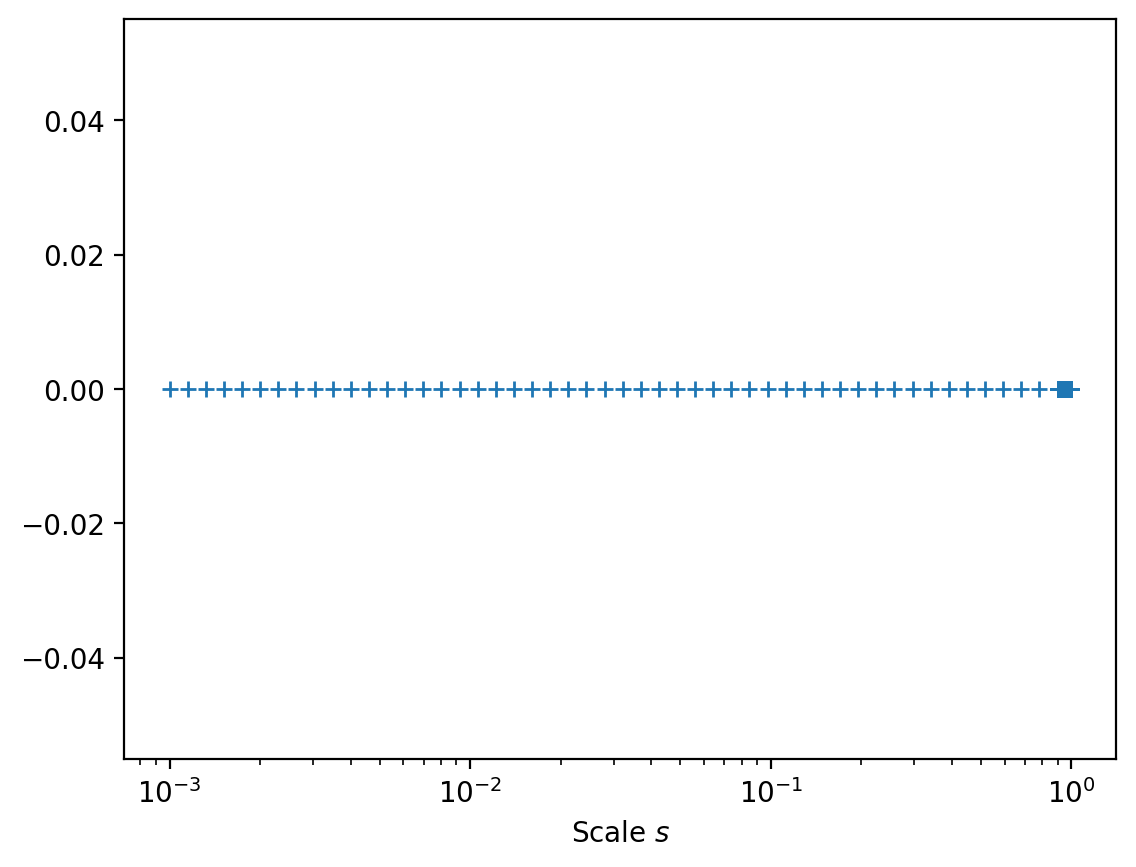

In [5]:
def rel_scales(npoints):
    return np.concatenate([np.geomspace(1e-3, .9, npoints // 3),
                           np.linspace(.9, 1 - 1e-9, npoints * 2 // 3)])


sample_scales = rel_scales(150)
plt.plot(rel_scales(150), rel_scales(150) * 0, "+")
plt.xlabel("Scale $s$")
plt.xscale("log")

## Setup

In [6]:
def plot_ev(ev_shape, ax=None):
    xi, = ev_shape.free_symbols

    if ax is None:
        ax = plt.gca()

    ax.axhline(float(sp.integrate(ev_shape, (xi, 0, 1))), c=".8", lw=1)
    cb.vis.sympy_plot((xi, 0, 1), ev_shape, ax=ax)
    ax.set_yticks([])
    ax.set_xticks([])

    ax.set_ylabel(r"$\lambda_i$")
    ax.grid(axis="y")

In [7]:
def ev_from_shape(ev_shape, dim):
    xi, = ev_shape.free_symbols
    xis = np.linspace(0, 1, dim)
    return sp.lambdify(xi, ev_shape)(xis)


def scale_evs(ev, n_scales):
    ev = ev / ev.mean()
    max_scale = float(1 / (1 - ev.min()))
    scales = rel_scales(n_scales) * max_scale
    ev = (ev[None] - 1) * scales[:, None] + 1
    # Remove degenerate cases
    ev = ev[np.all(np.abs(ev[:, 1:] - ev[:, :-1]) > 0, -1)]
    return ev


def compute_and_plot_bounds(ev, rot_count, n_scales):
    ev = scale_evs(ev, n_scales)

    dim = ev.shape[-1]
    dim_a = dim // 2
    dim_p = dim - dim_a

    loss = cb.compute_non_standardness(ev)

    # Evaluate
    loss_out = cb.compute_experiment(ev, dim_a, rot_count, cb.empiric.MODE_O)
    uloss_out = cb.compute_experiment(ev, dim_a, rot_count, cb.empiric.MODE_U)
    var_max_bound = cb.compute_var_max_bound(ev, dim_a)
    unitary_bound = cb.compute_unitary_bound(ev, dim_a, batch_size=1, prec=100000)
    loss_only_bound = cb.compute_loss_only_bound(ev, dim_a)

    # Plot
    x = loss
    # Experiment (Q)
    plt.plot(x, (loss_out.mean(1) / loss), "C0-", label="Experiment")
    q = .25  # IQR
    plt.fill_between(x,
                     (np.quantile(loss_out, q, axis=1) / loss),
                     (np.quantile(loss_out, 1-q, axis=1) / loss), alpha=.1)
    # Experiment (U)
    plt.plot(x, (uloss_out.mean(1) / loss), "C0--", label="Experiment (Unitary)")
    # Bounds
    plt.plot(x, unitary_bound / loss, "C1", label="'Unitary' Bound")
    plt.plot(x, var_max_bound / loss, "C2", label="'Var-max' Bound")
    plt.plot(x, loss_only_bound / loss, "C3", label="'Loss-only' Bound")

    plt.ylim(0, 1)
    plt.xscale("log")

    plt.legend(loc="lower left")
    plt.xlabel("non-Standardness before Block")
    plt.ylabel("Relative non-Standardness after Block")

    ax = plt.gca().inset_axes([0.75, 0.05, 0.2, 0.2])
    plot_ev(ev_shape, ax=ax)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

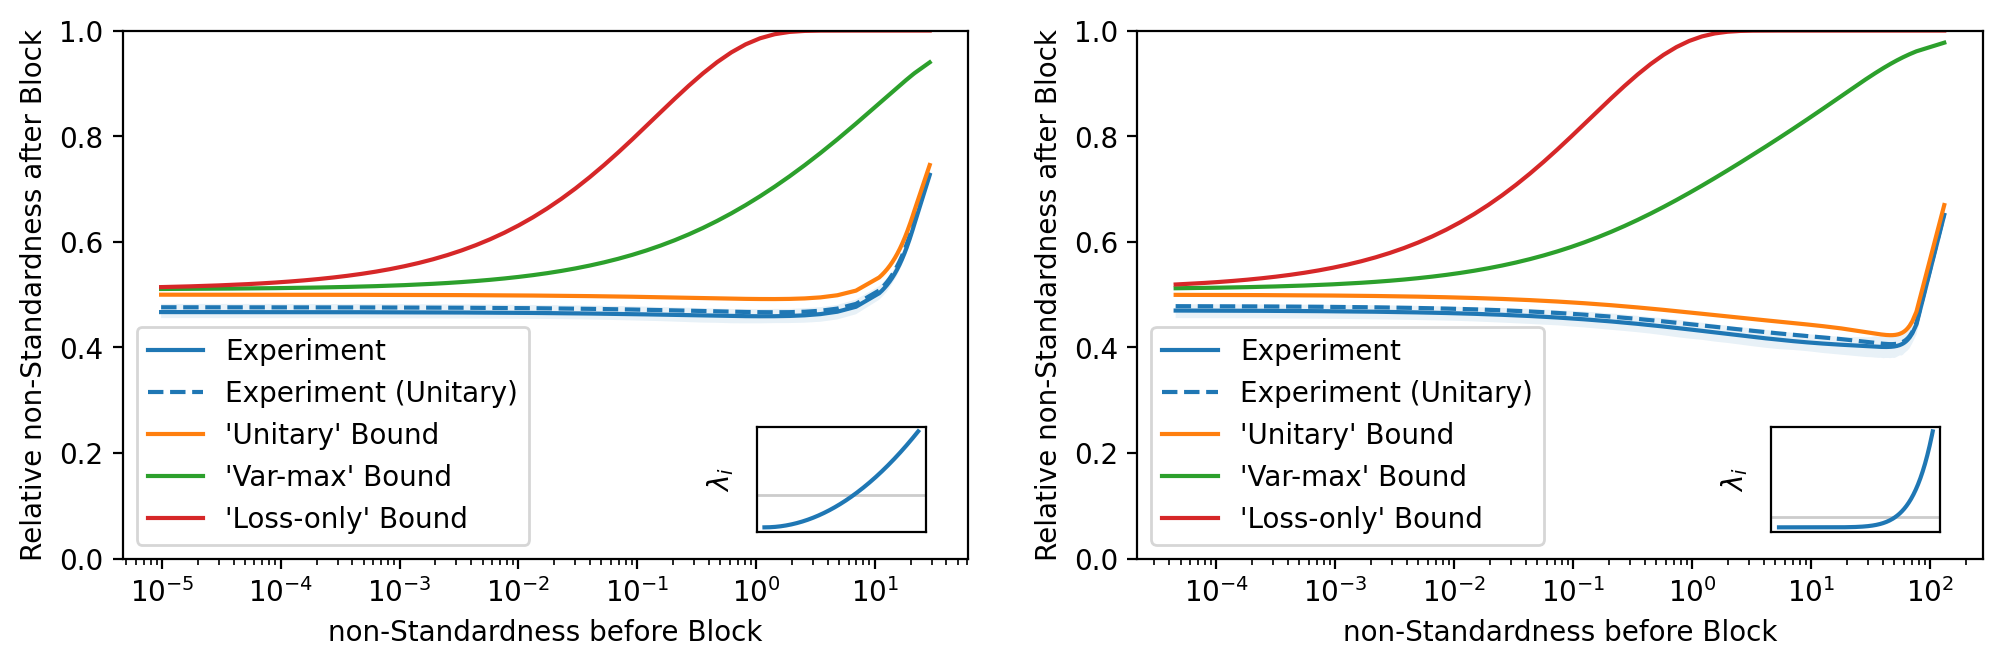

In [8]:
for p in cb.vis.iter_ax_grid([2, 8], figsize=(fig_width, fig_width / 3.5)):
    xi = sp.symbols("xi")
    ev_shape = xi ** p
    ev = ev_from_shape(ev_shape, 48)
    compute_and_plot_bounds(ev, 100, 150)

cb.vis.savefig(fig_dir / "bound-comparison-selected.pdf", bbox_inches="tight")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

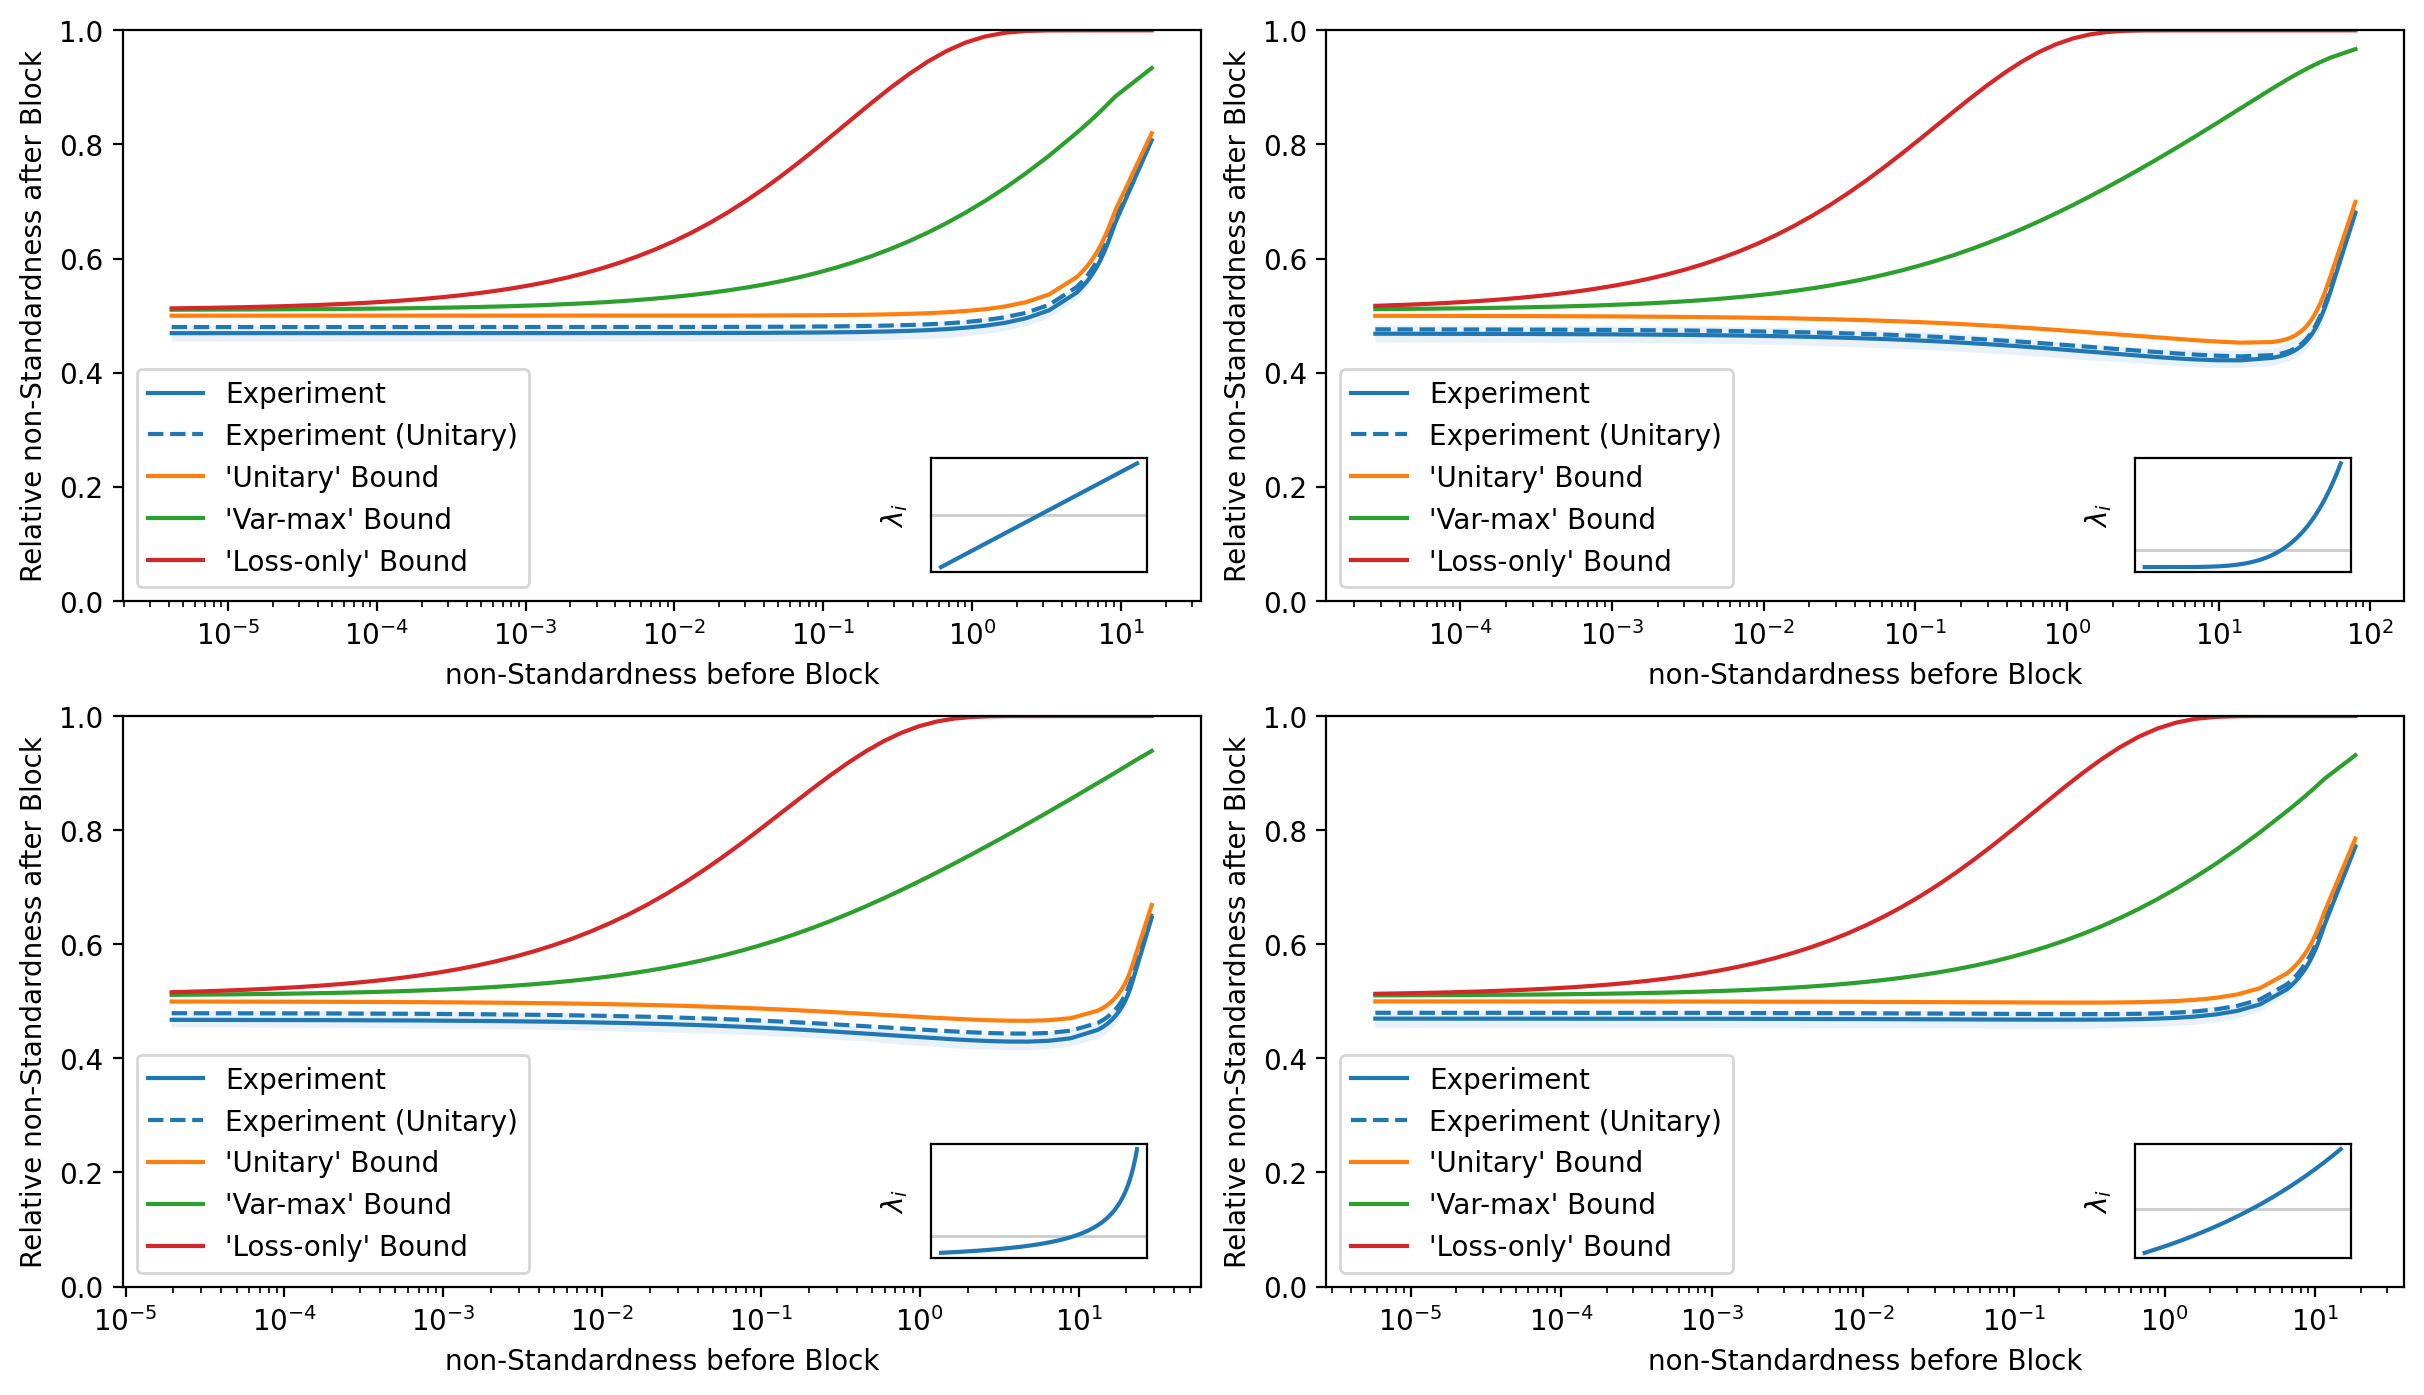

In [9]:
xi = sp.symbols("xi")
for ev_shape in cb.vis.iter_ax_grid([xi, xi ** 5, 1 / ((1 - xi) + sp.Rational(1, 10)), sp.exp(xi)],
                                    ncols=2, figsize=(fig_width, fig_width * 2 / 3.5), constrained_layout=True):
    ev = ev_from_shape(ev_shape, 48)
    compute_and_plot_bounds(ev, 100, 150)

cb.vis.savefig(fig_dir / "bound-comparison-more.pdf", bbox_inches="tight")

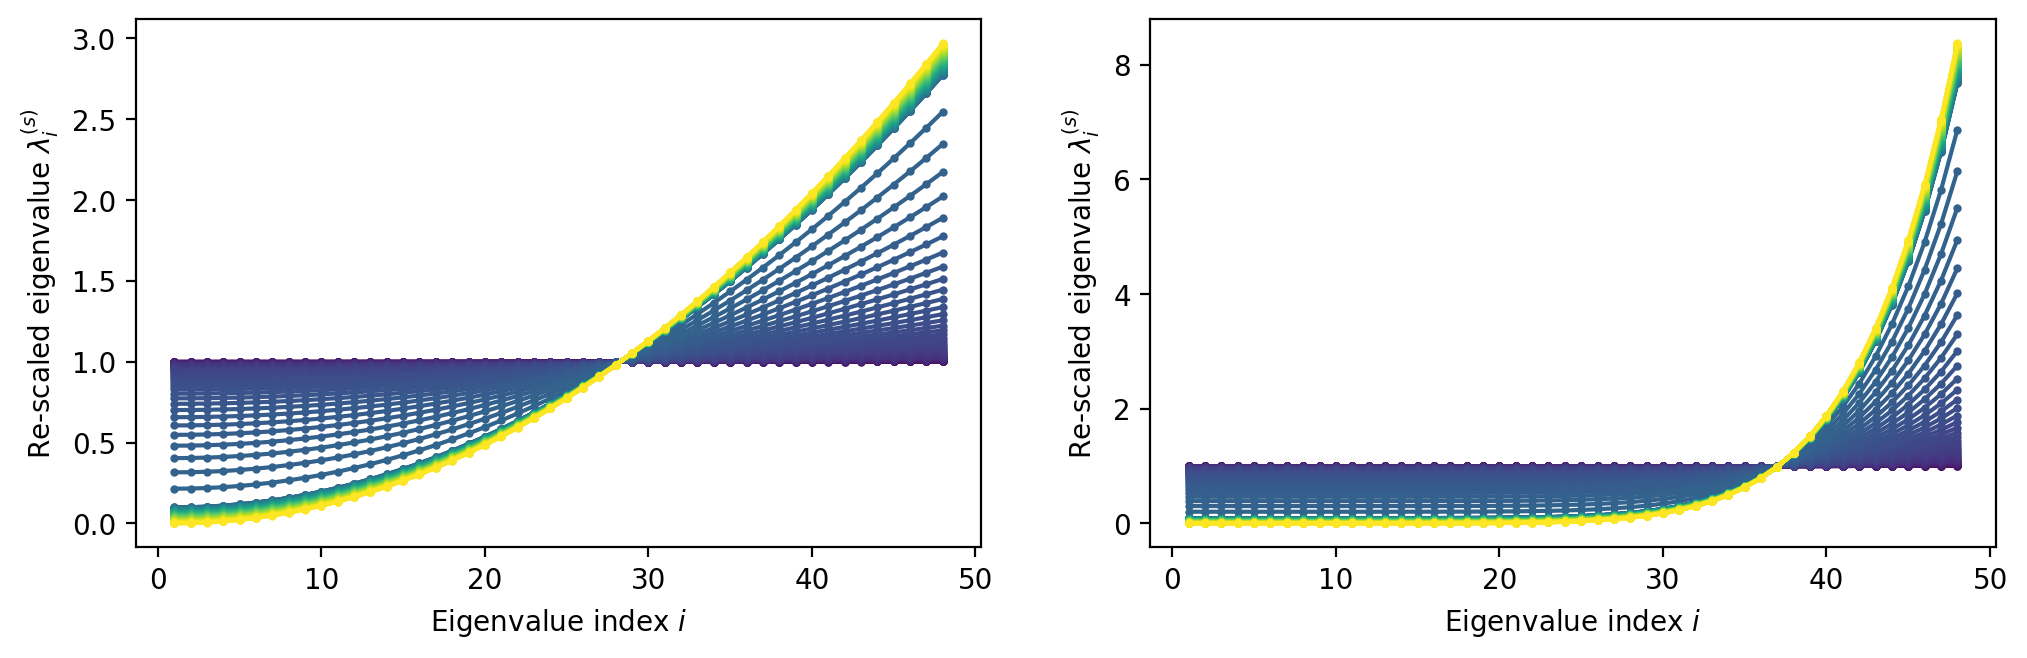

In [10]:
def show_shape(ev_shape, dim, n_scale):
    xi, = ev_shape.free_symbols
    span = ev_shape.subs(xi, 1) - ev_shape.subs(xi, 0)
    ev_shape = ev_shape / span
    ev_mean = sp.integrate(ev_shape, (xi, 0, 1))
    ev_shape

    s = sp.symbols("s")
    ev_shaped = (ev_shape - ev_mean) * s + 1
    max_scale = float(sp.solve(ev_shaped.subs(xi, 0), s)[0])

    scales = rel_scales(n_scale) * max_scale
    xis = np.linspace(0, 1, dim)
    ev_shaped_fn = sp.lambdify((s, xi), ev_shaped)
    ev = ev_shaped_fn(scales[:, None], xis[None])
    ev = ev / ev.mean(-1, keepdims=True)

    ev = ev[np.all(np.abs(ev[:, 1:] - ev[:, :-1]) > 0, -1)]

    plt.gca().set_prop_cycle(
        plt.cycler('color',
                   plt.get_cmap(cmaps['standard'])(np.linspace(0, 1, n_scale)))
    )
    plt.plot(np.arange(ev.shape[1]) + 1, ev.T, "o-", ms=2)
    plt.xlabel(r"Eigenvalue index $i$")
    plt.ylabel(r"Re-scaled eigenvalue $\lambda_i^{(s)}$")


for p in cb.vis.iter_ax_grid([2, 8], figsize=(fig_width, fig_width / 3.5)):
    xi = sp.symbols("xi")
    ev_shape = xi ** p
    show_shape(ev_shape, 48, 150)

plt.savefig(fig_dir / "bound-comparison-scaling-example.png", bbox_inches="tight", dpi=300)